In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [72]:
import tomllib
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()


if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py, and check the timestamp!")
df = pd.read_parquet(datafile)
#df.head()

In [73]:
def convert_to_decimal_hours(timestamp):
    dec_hour = timestamp.hour + timestamp.minute / 60 + timestamp.second / 3600
    return dec_hour

In [74]:
df["hour"] = df["timestamp"].apply(convert_to_decimal_hours)
df["log_len"] = df["message_length"].apply(lambda x: np.log(x))
dob_mapping = {'effervescent-camel': 2002, 'nimble-wombat':1971, 'hilarious-goldfinch':1972,
       'spangled-rabbit':2004}
df['dob'] = df['author'].map(dob_mapping)


In [75]:
#include age in the features (cleanup stage)
df['year'] = df["timestamp"].apply(lambda x: x.year)
df['age'] = df['year']-df['dob']
df.drop(['dob'], inplace=True, axis=1)

In [76]:
def convert_to_decimal_hours(timestamp):
    dec_hour = timestamp.hour + timestamp.minute / 60 + timestamp.second / 3600
    return dec_hour

df["hour"] = df["timestamp"].apply(convert_to_decimal_hours)
df["log_len"] = df["message_length"].apply(lambda x: np.log(x))
#df.head()


In [77]:
df_with_emoji =df[df['has_emoji']]
df_withou_emoji =df[df['has_emoji']==False]

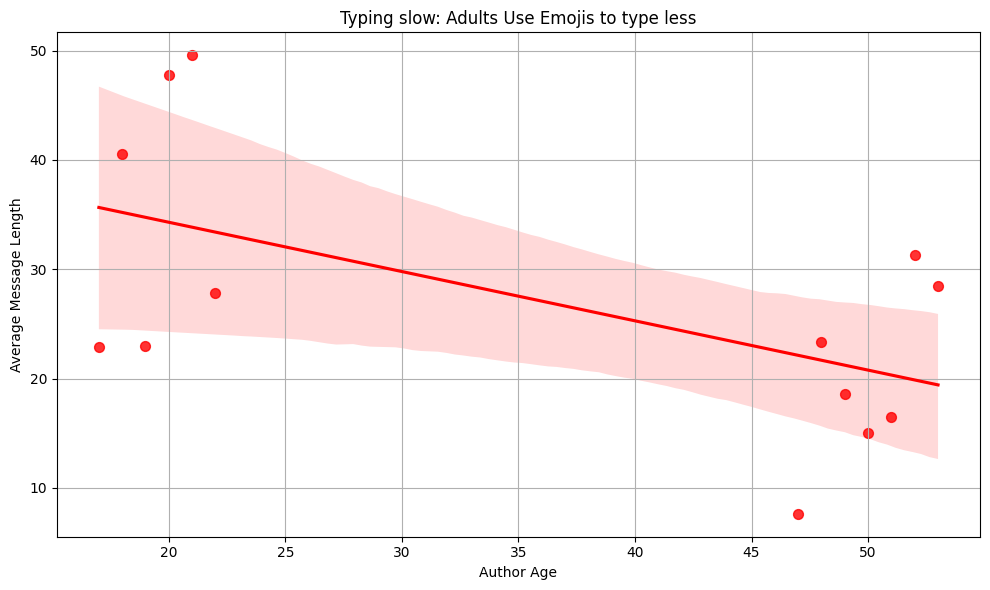

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df, df_em, and df_nem are already defined

# Calculate the average message length per age
avg_log_length_withemoji = df_em.groupby('age')['message_length'].mean().reset_index()
avg_log_length_without_emoji = df_nem.groupby('age')['message_length'].mean().reset_index()

# Create the regression plot
plt.figure(figsize=(10, 6), facecolor='white')

# Regression line for average length against age
line_with_emoji = sns.regplot(data=avg_log_length_withemoji, x='age', y='message_length', 
                               marker='o', scatter_kws={'s': 50}, color='red', label='With Emojis')
#line_without_emoji = sns.regplot(data=avg_log_length_without_emoji, x='age', y='message_length', 
#                                   marker='o', scatter_kws={'s': 10}, color='gray', label='Without Emojis')

# Add titles and labels
plt.title("Typing slow: Adults Use Emojis to type less")
plt.xlabel('Author Age')
plt.ylabel('Average Message Length')
plt.xticks()
plt.grid()



# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('average_message_length_vs_age.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()

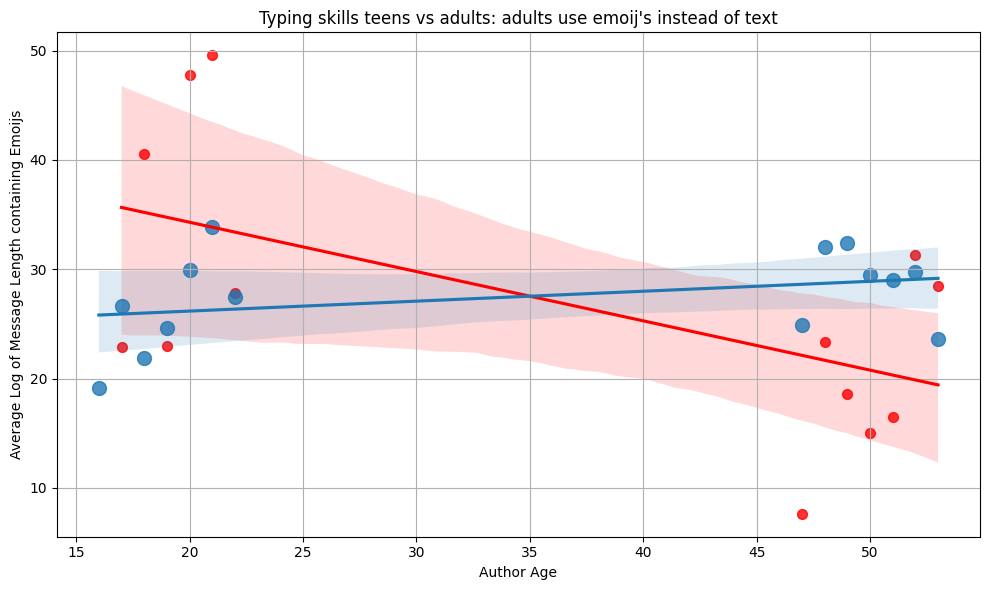

In [17]:
# Calculate the logarithm of message length
df['log_len'] = np.log(df['message_length'])

# Calculate the average log length per author
avg_log_length_withemoji = df_with_emoji.groupby('age')['message_length'].mean().reset_index()
avg_log_length_without_emoji = df_withou_emoji.groupby('age')['message_length'].mean().reset_index()

# Create the regression plot
plt.figure(figsize=(10, 6), facecolor='white')

# Regression line for average log length against age
sns.regplot(data=avg_log_length_withemoji, x='age', y='message_length', marker='o', scatter_kws={'s': 50}, color='red')
sns.regplot(data=avg_log_length_without_emoji, x='age', y='message_length', marker='o', scatter_kws={'s': 100})

# Add titles and labels
plt.title("Typing skills teens vs adults: adults use emoij's instead of text")
plt.xlabel('Author Age')
plt.ylabel('Average Log of Message Length containing Emoijs')
plt.xticks()
plt.grid()

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('average_log_length_vs_age.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()

<Axes: xlabel='message_length', ylabel='has_emoji'>

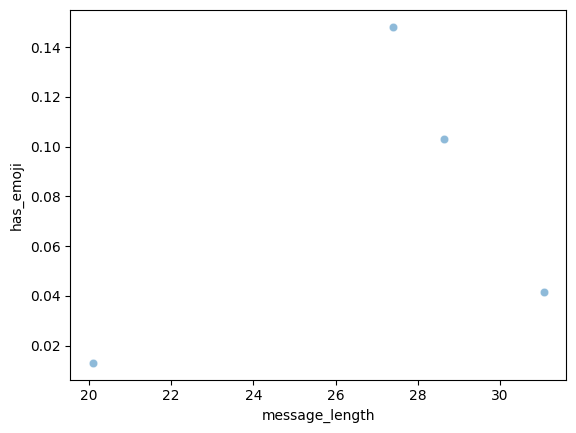

In [20]:
p = df.groupby(["author"]).agg({
    "message_length": "mean",
    "has_emoji": "mean",
    "author": "count"
    
}).rename(columns={"author": "count"})

p = p[p["count"] > 10]
sns.scatterplot(data=p, x="message_length", y="has_emoji", alpha=0.5)


<Axes: xlabel='message_length', ylabel='has_emoji'>

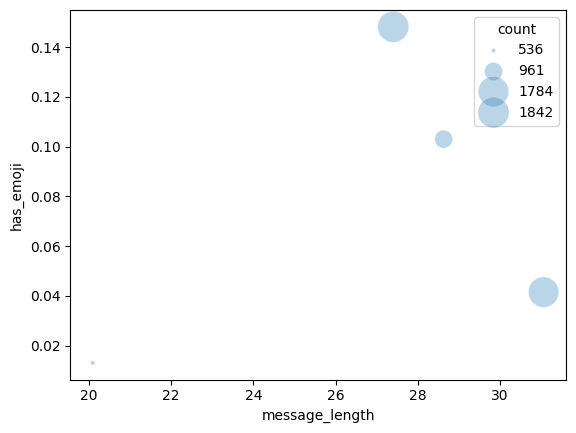

In [21]:
sns.scatterplot(data=p, x="message_length", y="has_emoji", size="count", sizes=(10, 500), alpha=0.3)

In [22]:
df_em =df[df['has_emoji']]
df_nem =df[df['has_emoji']==False]

In [23]:
p_without_emoji=df_nem.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean",
}).rename(columns={"author": "count"})

In [24]:
p2=df_em.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean",
    "has_emoji": "count"
}).rename(columns={"author": "count"})

<Axes: xlabel='age', ylabel='message_length'>

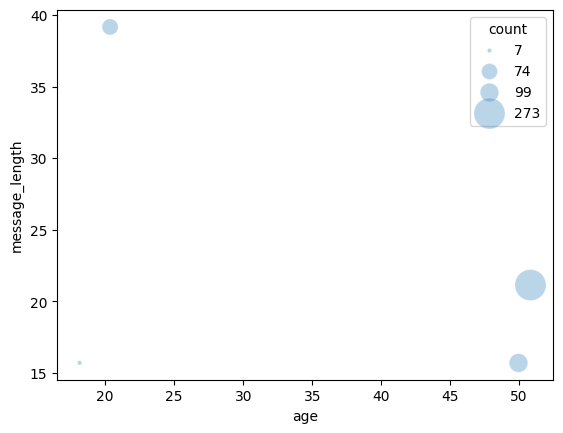

In [25]:
sns.scatterplot(data=p2, x="age", y="message_length", size="count", sizes=(10, 500), alpha=0.3)
#sns.scatterplot(data=p_without_emoji, x="age", y="message_length", size="count", sizes=(10, 500), alpha=0.3)

In [26]:
p_with_emoji =df_em.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean"
}).rename(columns={"author": "count"})

In [27]:
p_with_emoji['diff_length'] = p_with_emoji['message_length']- p_without_emoji['message_length']

<Axes: xlabel='age', ylabel='count'>

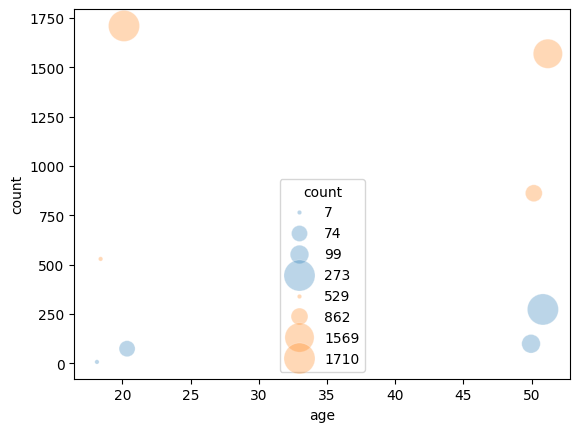

In [28]:
sns.scatterplot(data=p_with_emoji, x="age", y="count", size="count",  sizes=(10, 500), alpha=0.3)
sns.scatterplot(data=p_without_emoji, x="age", y="count", size="count", sizes=(10, 500), alpha=0.3)

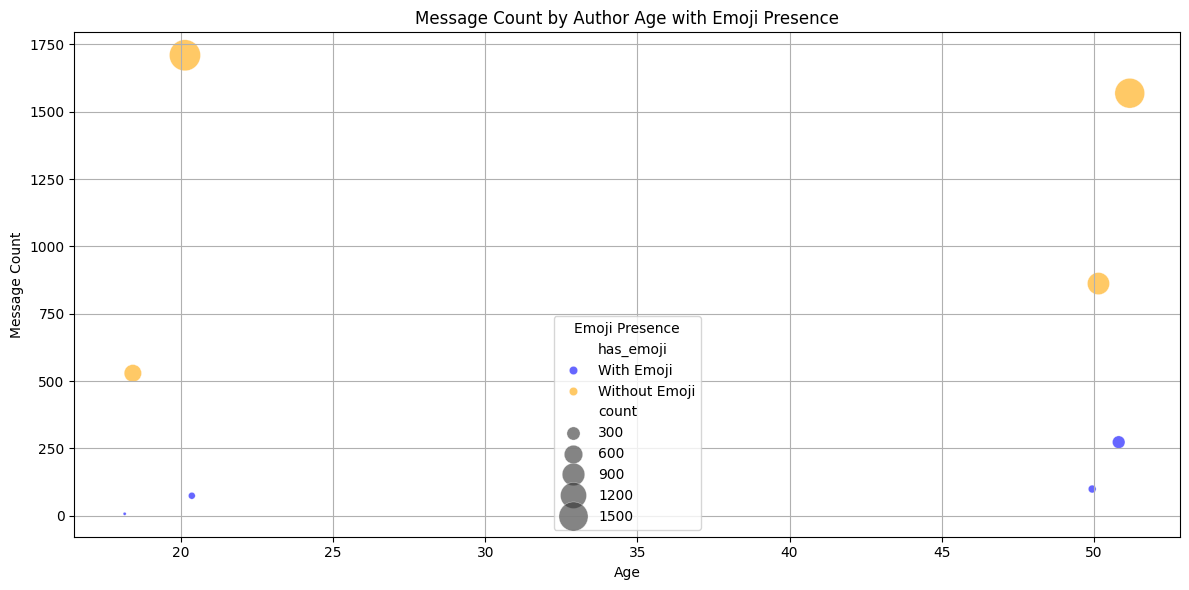

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming p_with_emoji and p_without_emoji are already created

# Add a column to indicate emoji presence
p_with_emoji['has_emoji'] = 'With Emoji'
p_without_emoji['has_emoji'] = 'Without Emoji'

# Concatenate the two DataFrames
combined_data = pd.concat([p_with_emoji, p_without_emoji])

# Create the scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=combined_data, x="age", y="count", 
                size="count", sizes=(5, 500), alpha=0.6, 
                hue='has_emoji', palette={'With Emoji': 'blue', 'Without Emoji': 'orange'})

# Add titles and labels
plt.title('Message Count by Author Age with Emoji Presence')
plt.xlabel('Age')
plt.ylabel('Message Count')

# Add a legend and grid
plt.legend(title='Emoji Presence')
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


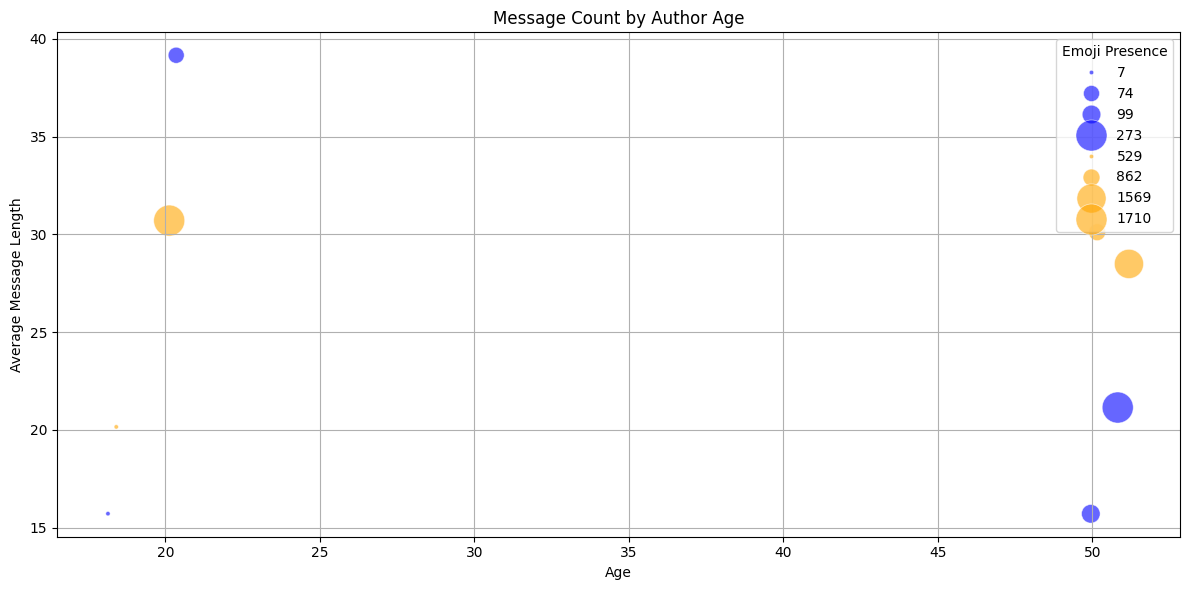

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate aggregated data for authors with emojis
p_with_emoji = df_em.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean"
}).rename(columns={"author": "count"})

# Calculate aggregated data for authors without emojis
p_without_emoji = df_nem.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean"
}).rename(columns={"author": "count"})

# Create the scatter plot
plt.figure(figsize=(12, 6))

# Scatter plot for authors with emojis
sns.scatterplot(data=p_with_emoji, x="age", y="message_length", 
                size="count", sizes=(10, 500), alpha=0.6, 
                color='blue')

# Scatter plot for authors without emojis
sns.scatterplot(data=p_without_emoji, x="age", y="message_length", 
                size="count", sizes=(10, 500), alpha=0.6, 
                color='orange')

# Add titles and labels
plt.title('Message Count by Author Age')
plt.xlabel('Age')
plt.ylabel('Average Message Length')

# Add a legend
plt.legend(title='Emoji Presence')

# Show grid and layout
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
df_em.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean"
}).rename(columns={"author": "count"})

In [ ]:
df.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count",
    "age": "mean"
}).rename(columns={"author": "count"})

In [33]:
p2 = df.groupby(["author"]).agg({
    "message_length": "mean",
    "author": "count"
}).rename(columns={"author": "count"})

<Axes: xlabel='message_length', ylabel='count'>

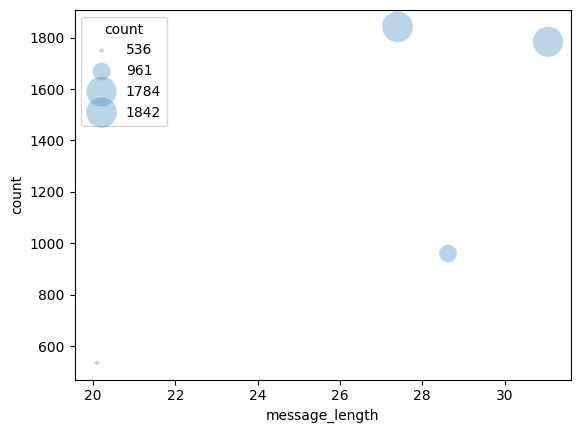

In [34]:
sns.scatterplot(data=p, x="message_length", y="count", size="count", sizes=(10, 500), alpha=0.3)

In [36]:
p["message_length"] /= p["message_length"].max()
p["has_emoji"] /= p["has_emoji"].max()
p["color"] = p.apply(lambda x: "grey" if x["message_length"] > x["has_emoji"] else "red", axis=1)


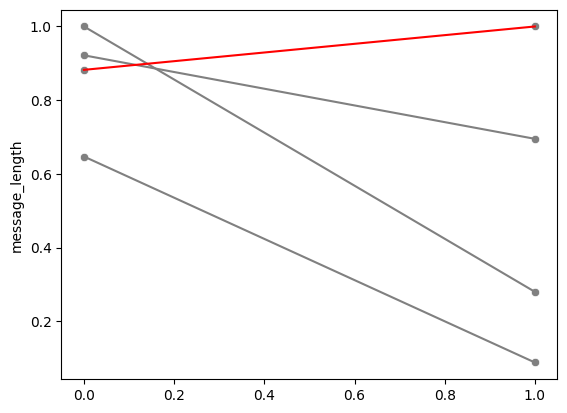

In [37]:
sns.scatterplot(data=p, y="message_length", x=0, color="grey")
sns.scatterplot(data=p, y="has_emoji", x=1, color="grey")
for index, row in p.iterrows():
    sns.lineplot(x=[0, 1], y=[row["message_length"], row["has_emoji"]], color=row["color"])

In [40]:
p.reset_index()
p.columns

Index(['message_length', 'has_emoji', 'count', 'color'], dtype='object')

In [41]:
#df_em[df_em['timestamp_category']=='late']

In [ ]:
# Calculate the average presence of emojis by time category
average_emoji = df.groupby('hour')['has_emoji'].mean().reset_index()
average_emoji = average_emoji.sort_values(by='has_emoji', ascending=False)
average_emoji

C:\Users\Francesca\AppData\Local\Temp\ipykernel_21688\976573939.py:15: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(data=average_emoji, x='author', y='message_length', palette=colors)


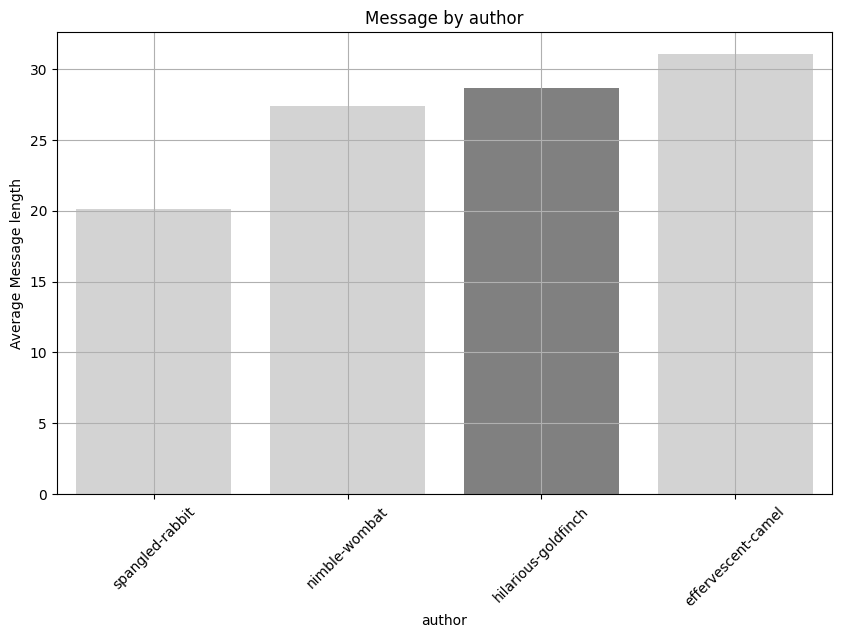

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the average presence of emojis by time category
average_emoji = df.groupby('author')['message_length'].mean().reset_index()

# Sort the DataFrame in descending order based on average emoji presence
average_emoji = average_emoji.sort_values(by='message_length', ascending=True)

# Step 2: Create the bar plot
plt.figure(figsize=(10, 6))
colors = ['lightgray', 'lightgray', 'gray', 'lightgray', 'salmon']
sns.barplot(data=average_emoji, x='author', y='message_length', palette=colors)

# Customize the plot
plt.title('Message by author')
plt.xlabel('author')
plt.ylabel('Average Message length')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(True)

# Save the plot with an opaque background
plt.savefig('bar_plot_average_emoji_presence.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()

In [ ]:
df_emj= df[df['has_emoji']]
df_emj['age']

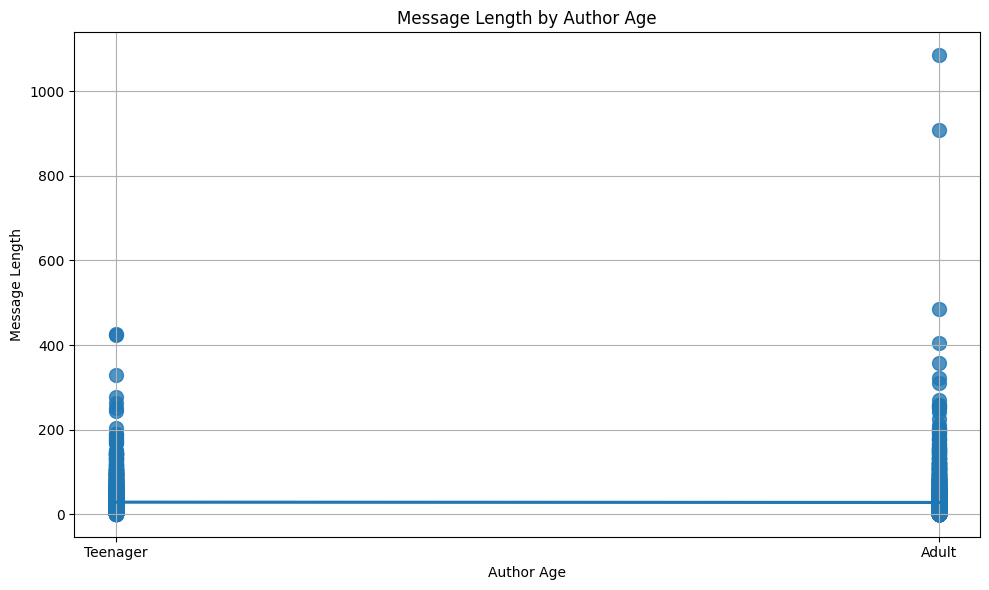

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame setup (assuming df is already defined with relevant columns)
# df = pd.DataFrame(...)  # Your DataFrame goes here

# Assign categories to each author
category_mapping = {
    'effervescent-camel': 'teenager',
    'hilarious-goldfinch': 'adult',
    'nimble-wombat': 'adult',
    'spangled-rabbit': 'teenager'
}
df['category'] = df['author'].map(category_mapping)

# Calculate the length of messages
df['message_length'] = df['message'].str.len()  # Adjust this based on how your messages are structured

# Map authors to a numerical age value for plotting
age_mapping = {
    'teenager': 15,  # Example age for teenagers
    'adult': 30      # Example age for adults
}
df['age'] = df['category'].map(age_mapping)

# Create the regression plot
plt.figure(figsize=(10, 6), facecolor='white')

# Regression line for message length against author age
sns.regplot(data=df, x='age', y='message_length', marker='o', scatter_kws={'s': 100})

# Add titles and labels
plt.title("Message Length by Author Age")
plt.xlabel('Author Age')
plt.ylabel('Message Length')
plt.xticks(ticks=[15, 30], labels=['Teenager', 'Adult'])
plt.grid()

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('message_length_vs_age.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()


<Figure size 800x600 with 0 Axes>

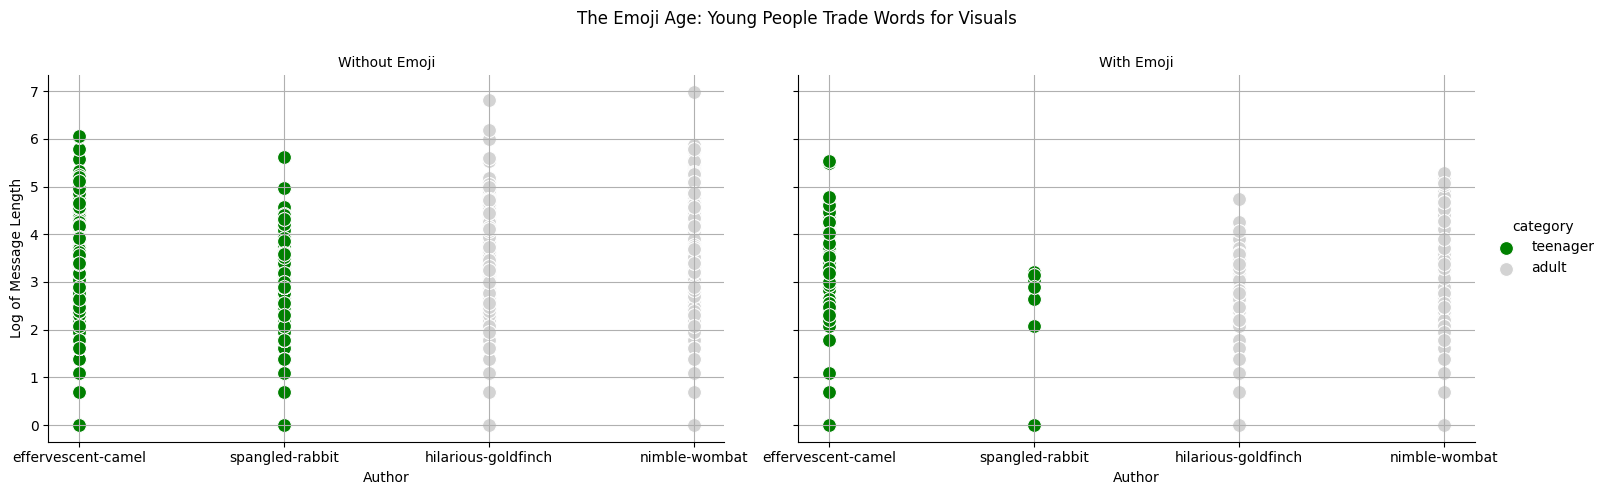

In [53]:
# Assign categories to each author
category_mapping = {
    'effervescent-camel': 'teenager',
    'hilarious-goldfinch': 'adult',
    'nimble-wombat': 'adult',
    'spangled-rabbit': 'teenager'
}
df['category'] = df['author'].map(category_mapping)

# Calculate the logarithm of message length
df['log_len'] = np.log(df['message_length'])

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Sort the DataFrame by author
df_sorted = df.sort_values(by='author')

# Create the scatter plot
plt.figure(figsize=(8, 6), facecolor='white')  
# Create a FacetGrid
g = sns.FacetGrid(df_sorted, col='emoji_status', hue='category', height=5, aspect=1.5, palette={'teenager': 'green', 'adult': 'lightgray'})

# Map the scatter plot to each facet (note that x and y are swapped)
g.map(sns.scatterplot, 'author', 'log_len', s=100)

# Add count annotations
for ax in g.axes.flat:
    # Get the title to determine the emoji status
    emoji_status = ax.get_title().split(' ')[0]  # "With" or "Without"
    
    # Filter the DataFrame based on the emoji status
    for i in range(df_sorted.shape[0]):
        if df_sorted['emoji_status'].iloc[i] == emoji_status:
            ax.text(df_sorted['author'].iloc[i], df_sorted['log_len'].iloc[i], df_sorted['count'].iloc[i], 
                    fontsize=9, ha='right', va='center')

    # Add grid to the axes
    ax.grid(True)

# Add titles and labels
g.set_axis_labels('Author', 'Log of Message Length')
g.set_titles(col_template='{col_name}')

# Add a legend
g.add_legend()

# Adjust layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle("The Emoji Age: Young People Trade Words for Visuals")
plt.grid(True)

# Save the plot
#plt.savefig('4_scatter_plot_with_emojis.png', bbox_inches='tight', transparent=False)  # Save after all plotting commands

# Save the plot with an opaque background
plt.savefig('4_scatter_plot_with_emojis.png', bbox_inches='tight', transparent=False)
# Show the plot
plt.show()

In [55]:
# Assign categories to each author
category_mapping = {
    'effervescent-camel': 'teenager',
    'hilarious-goldfinch': 'adult',
    'nimble-wombat': 'adult',
    'spangled-rabbit': 'teenager'
}
df['category'] = df['author'].map(category_mapping)

# Calculate the logarithm of message length
df['log_len'] = np.log(df['message_length'])

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Sort the DataFrame by author
df_sorted = df.sort_values(by='author')


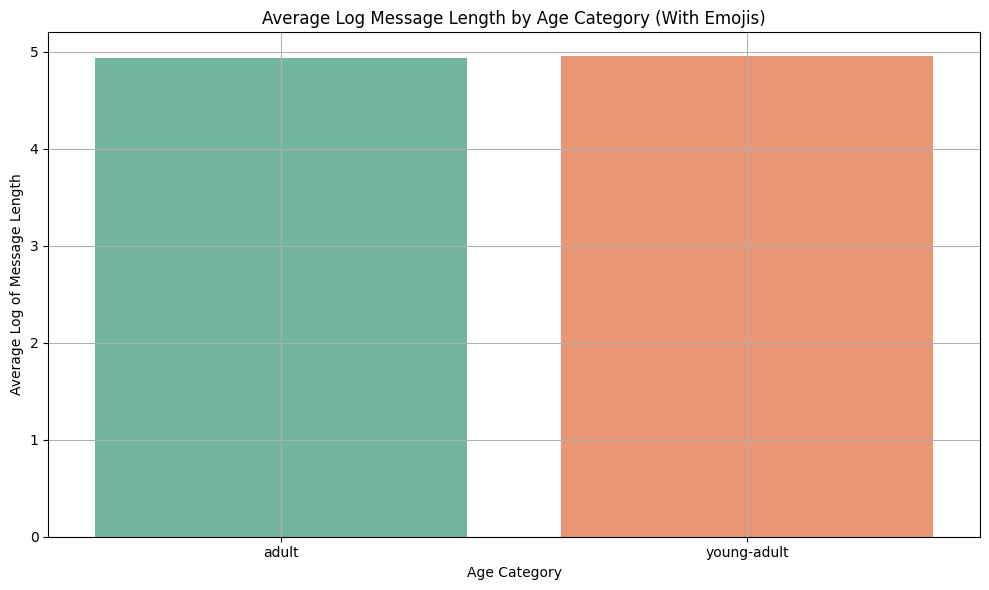

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame setup
data = {
    'author': ['effervescent-camel', 'hilarious-goldfinch', 'nimble-wombat', 'spangled-rabbit'],
    'message_length': [100, 150, 200, 130],
    'has_emoji': [1, 0, 1, 0],
    'count': [5, 10, 7, 2]
}

df = pd.DataFrame(data)

# Assign age categories to each author
category_mapping = {
    'effervescent-camel': 'young-adult',
    'hilarious-goldfinch': 'adult',
    'nimble-wombat': 'young-adult',
    'spangled-rabbit': 'adult'
}

# Create a column for age category
df['age_category'] = df['author'].map(category_mapping)

# Calculate the logarithm of message length
df['log_len'] = np.log(df['message_length'])

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Filter the DataFrame for messages with emojis
df_with_emojis = df[df['emoji_status'] == 'With Emoji']

# Step 1: Group by age category and calculate mean log_len
mean_lengths = df.groupby('age_category')['log_len'].mean().reset_index()

# Step 2: Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_lengths, x='age_category', y='log_len', palette='Set2')
plt.title('Average Log Message Length by Age Category (With Emojis)')
plt.xlabel('Age Category')
plt.ylabel('Average Log of Message Length')
plt.grid(True)
plt.tight_layout()

# Save the plot with an opaque background
plt.savefig('bar_plot_average_log_length.png', bbox_inches='tight', transparent=False)

# Show the plot
plt.show()



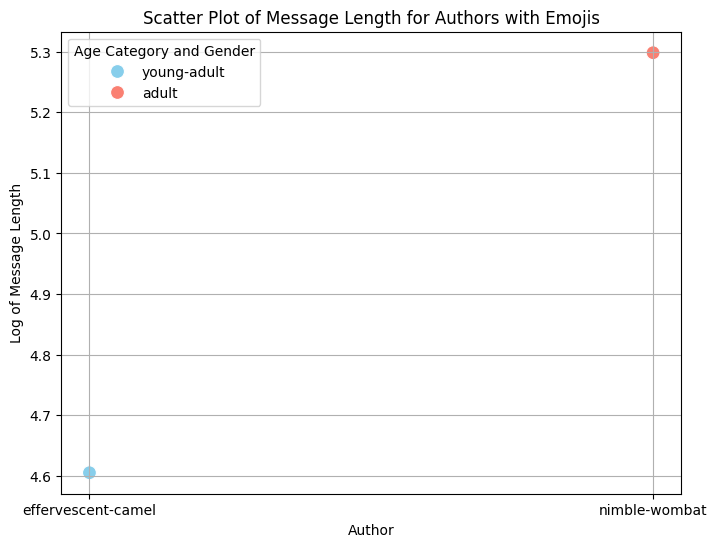

In [58]:
# Assign genders and age categories to each author
category_mapping = {
    'effervescent-camel': ('F', 'young-adult'),
    'hilarious-goldfinch': ('F', 'adult'),
    'nimble-wombat': ('M', 'adult'),
    'spangled-rabbit': ('M', 'young-adult')
}

# Create separate columns for gender and age category
df['gender'], df['age_category'] = zip(*df['author'].map(category_mapping))

# Calculate the logarithm of message length
df['log_len'] = np.log(df['message_length'])

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Filter the DataFrame for messages with emojis
df_with_emojis = df[df['emoji_status'] == 'With Emoji']

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_with_emojis, x='author', y='log_len', hue='age_category',  s=100, palette={'young-adult': 'skyblue', 'adult': 'salmon'})



# Add titles and labels
plt.title('Scatter Plot of Message Length for Authors with Emojis')
plt.xlabel('Author')
plt.ylabel('Log of Message Length')
plt.grid(True)
plt.legend(title='Age Category and Gender')
plt.show()

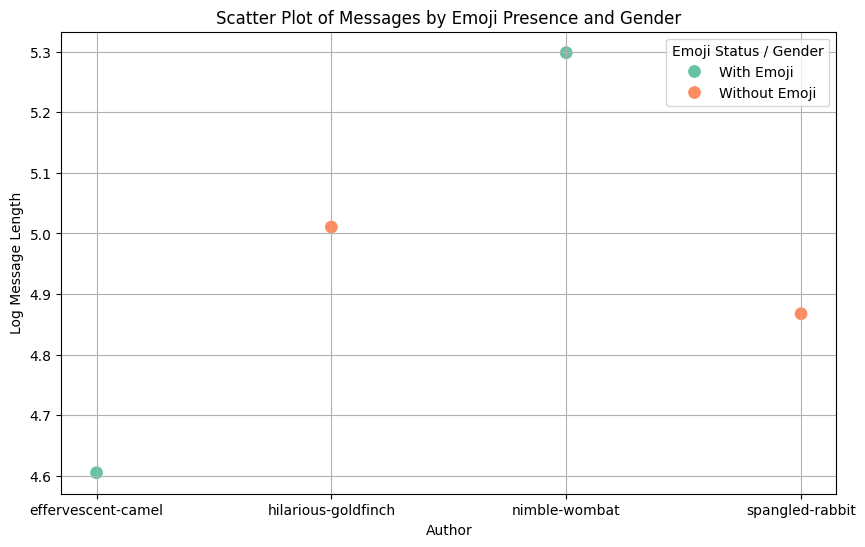

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




# Assign genders to each author
gender_mapping = {
    'effervescent-camel': 'F',
    'hilarious-goldfinch': 'F',
    'nimble-wombat': 'M',
    'spangled-rabbit': 'M'
}

df['gender'] = df['author'].map(gender_mapping)

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='author', y='log_len', hue='emoji_status', palette='Set2', s=100)

plt.title('Scatter Plot of Messages by Emoji Presence and Gender')
plt.xlabel('Author')
plt.ylabel('Log Message Length')
plt.legend(title='Emoji Status / Gender')
plt.grid(True)
plt.show()


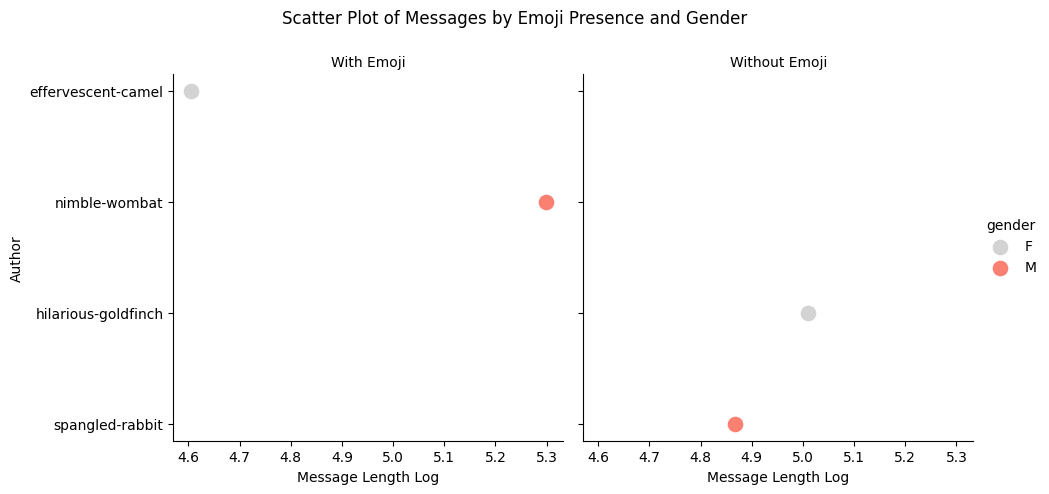

In [60]:
df['gender'] = df['author'].map(gender_mapping)

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Create a color palette
custom_palette = {'F': 'lightgray', 'M': 'salmon'}

# Create the FacetGrid
g = sns.FacetGrid(df, col='emoji_status', hue='gender', height=5, aspect=1, palette=custom_palette)


# Map the scatter plot to each facet
g.map(sns.scatterplot, 'log_len', 'author', s=150)
g.add_legend()

# Add titles and labels
g.set_axis_labels('Message Length Log', 'Author')
g.set_titles(col_template='{col_name}')

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Scatter Plot of Messages by Emoji Presence and Gender')
plt.show()

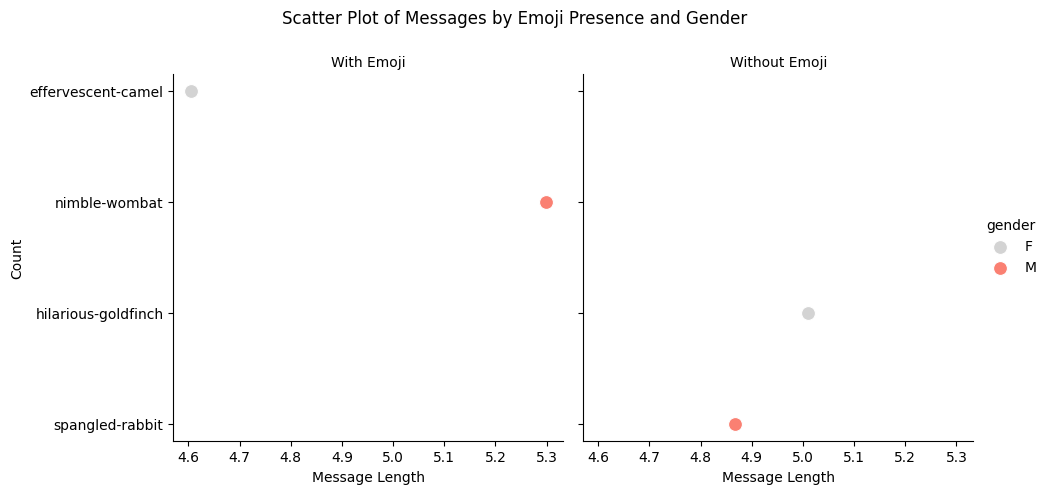

In [61]:
df['gender'] = df['author'].map(gender_mapping)

# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Create a custom color palette for genders
gender_palette = {'F': 'skyblue', 'M': 'salmon'}


# Create the FacetGrid
g = sns.FacetGrid(df, col='emoji_status', hue='gender', height=5, aspect=1, palette=custom_palette)

# Map the scatter plot to each facet
g.map(sns.scatterplot, 'log_len', 'author', s=100)

# Add a legend
g.add_legend()

# Set titles and labels
g.set_axis_labels('Message Length', 'Count')
g.set_titles(col_template='{col_name}')




plt.subplots_adjust(top=0.85)
g.fig.suptitle('Scatter Plot of Messages by Emoji Presence and Gender')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

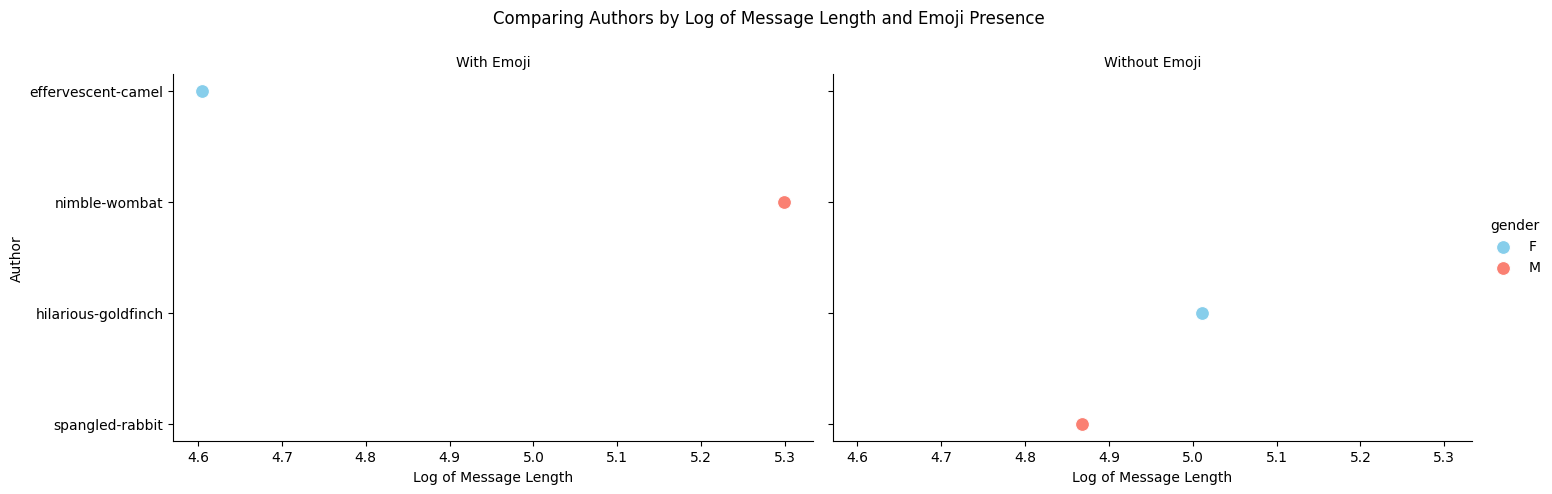

In [62]:
# Create a new column to categorize messages based on emoji presence
df['emoji_status'] = df['has_emoji'].apply(lambda x: 'With Emoji' if x > 0 else 'Without Emoji')

# Create a FacetGrid
g = sns.FacetGrid(df, col='emoji_status', hue='gender', height=5, aspect=1.5, palette={'F': 'skyblue', 'M': 'salmon'})

# Map the scatter plot to each facet
g.map(sns.scatterplot, 'log_len', 'author', s=100)

# Add titles and labels
g.set_axis_labels('Log of Message Length', 'Author')
g.set_titles(col_template='{col_name}')

# Add a legend
g.add_legend()

# Adjust layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Comparing Authors by Log of Message Length and Emoji Presence')
plt.show

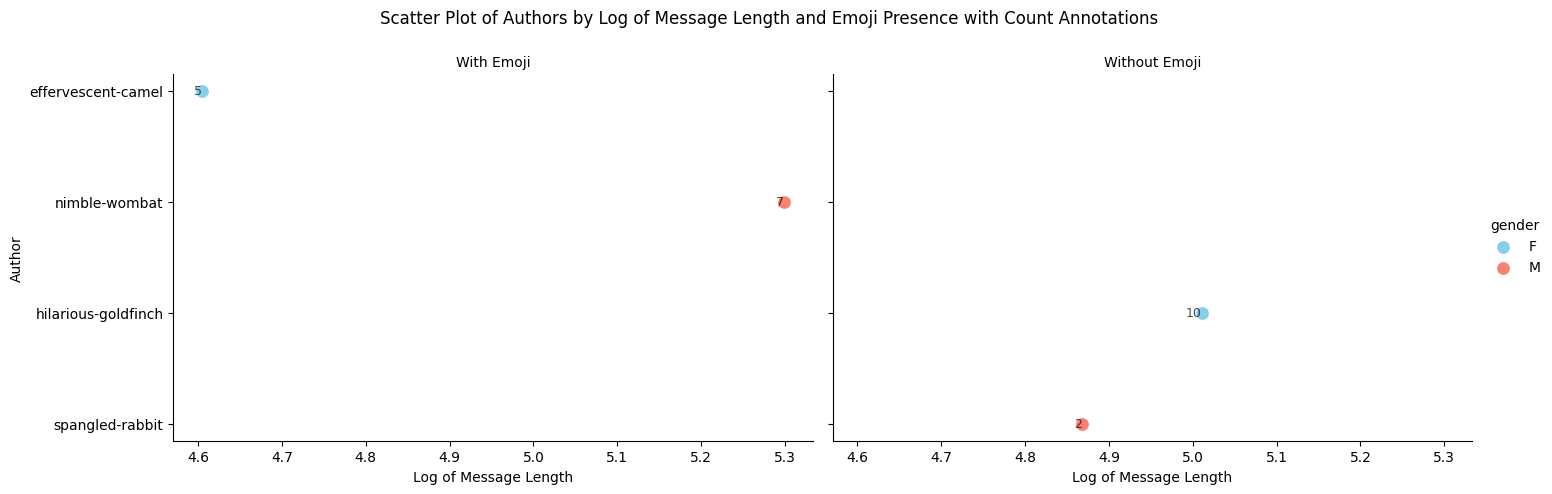

In [63]:
# Create a FacetGrid
g = sns.FacetGrid(df, col='emoji_status', hue='gender', height=5, aspect=1.5, palette={'F': 'skyblue', 'M': 'salmon'})

# Map the scatter plot to each facet
g.map(sns.scatterplot, 'log_len', 'author', s=100)



# Add count annotations
for ax in g.axes.flat:
    for i in range(df.shape[0]):
        # Get the correct axis based on emoji status
        if df['emoji_status'][i] in ax.get_title():
            ax.text(df['log_len'][i], df['author'][i], df['count'][i], 
                    fontsize=9, ha='right', va='center', alpha=0.7)

# Add titles and labels
g.set_axis_labels('Log of Message Length', 'Author')
g.set_titles(col_template='{col_name}')

# Add a legend
g.add_legend()

# Adjust layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Scatter Plot of Authors by Log of Message Length and Emoji Presence with Count Annotations')
plt.show()

Lowess stands for Locally Weighted Scatterplot Smoothing, and it is a non-parametric regression method that fits a smooth curve to the data. It is a useful tool to explore the relationship between two variables, but it is not a model in the traditional sense. It is a tool to help us understand the data, not to make predictions.

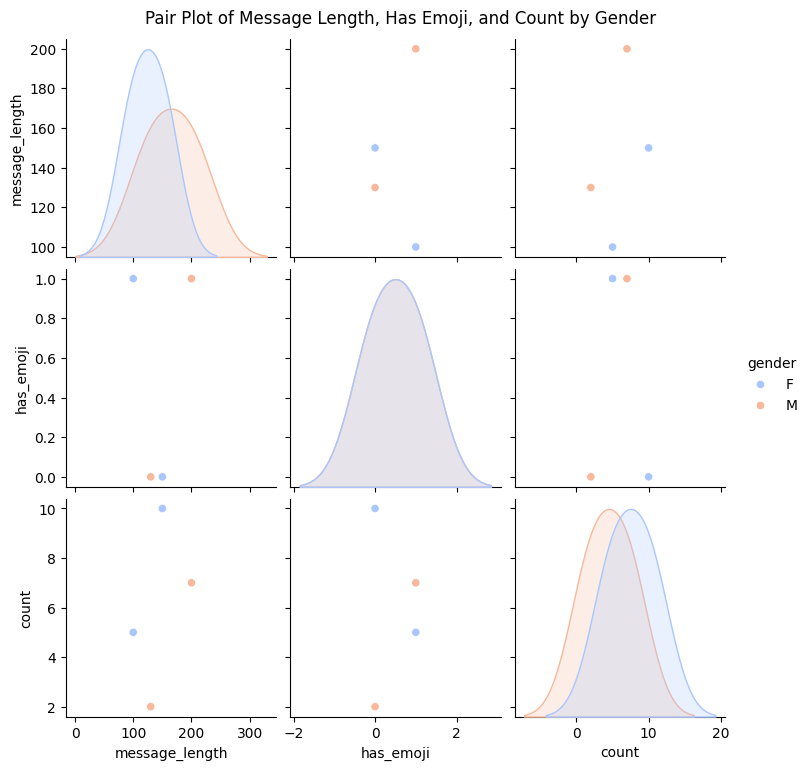

In [65]:
# Select only relevant columns for pair plot
sns.pairplot(df, hue='gender', vars=['message_length', 'has_emoji', 'count'], palette='coolwarm')
plt.suptitle('Pair Plot of Message Length, Has Emoji, and Count by Gender', y=1.02)
plt.show()

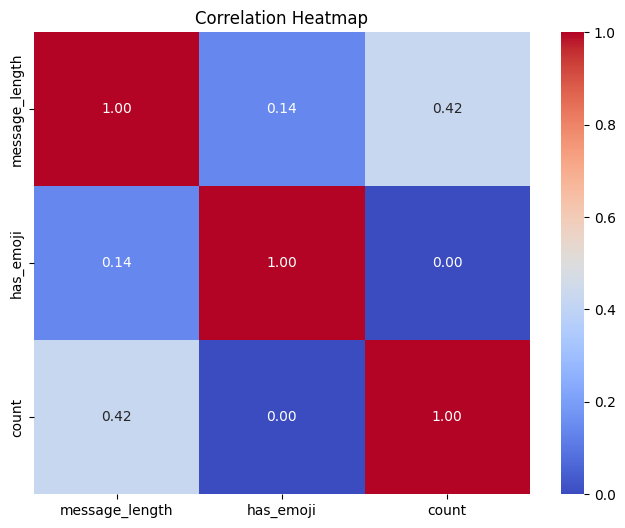

In [66]:
# Calculate the correlation matrix using only numeric columns
correlation_matrix = df[['message_length', 'has_emoji', 'count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()



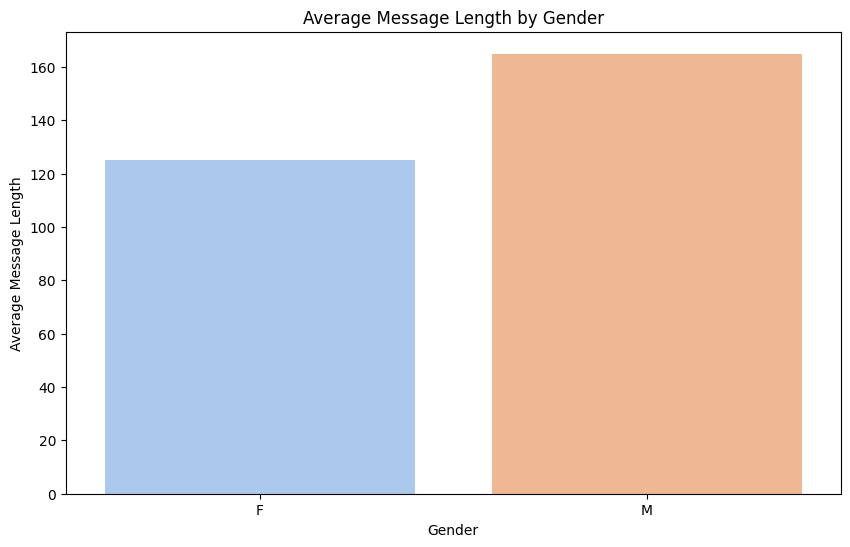

In [67]:
# Calculate average message length and count by gender
avg_df = df.groupby('gender').agg({'message_length': 'mean', 'count': 'mean'}).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_df, x='gender', y='message_length', palette='pastel')
plt.title('Average Message Length by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Message Length')
plt.show()
